In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from collections import defaultdict

In [2]:
import os
import sys

# Get the absolute path of src/ directory
notebooks_path = os.path.abspath(os.getcwd())  # Get the notebook’s current directory
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))

# Ensure src is in sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)  # Insert at the beginning to prioritize it

# Import necessary modules from src
from Measure_sampling.Gen_Path_and_AdaptedTrees import *
from trees.Tree_Node import *
from trees.TreeAnalysis import *
from trees.TreeVisualization import *
from trees.Save_Load_trees import *
from trees.Tree_AWD_utilities import *

from benchmark_value_gaussian.Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from awd_trees.Gurobi_AOT import *
from awd_trees.Nested_Dist_Algo import compute_nested_distance

from Conditional_density.CD_nonparam import *

from AOT_numerics.mainfunctions import *
from AOT_numerics.measure import *
from AOT_numerics.normal_ot import *
from AOT_numerics.FVI_bench import *

from Measure_sampling.Extract_Sample_path_AOT import extract_sample_paths

from adapted_empirical_measure.AEM_kMeans import (
    empirical_k_means_measure,
    empirical_k_means_measure_new,
    empirical_k_means_measure_grid,
)
from adapted_empirical_measure.AEM_grid import empirical_grid_measure, uniform_empirical_grid_measure


In [13]:
dim = 3            # Change this to any dimension you like
n_sample = 1500   # Number of sample paths
normalize = False  # Whether to normalize the factor matrices

In [14]:
import numpy as np

L0 = np.array([[1, 0, 0], [1, 2, 0], [1, 2, 3]])
A0 = L0 @ L0.T  # A = LL^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T

M0 = np.array([[1, 0, 0], [2, 1, 0], [3, 2, 1]])
B0 = M0 @ M0.T  # B = MM^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T

In [15]:
print("L:")
print(L)
print("A = LL^T:")
print(A)
print("\nM:")
print(M)
print("B = MM^T:")
print(B)

L:
[[1 0 0]
 [1 2 0]
 [1 2 3]]
A = LL^T:
[[ 1  1  1]
 [ 1  5  5]
 [ 1  5 14]]

M:
[[1 0 0]
 [2 1 0]
 [3 2 1]]
B = MM^T:
[[ 1  2  3]
 [ 2  5  8]
 [ 3  8 14]]


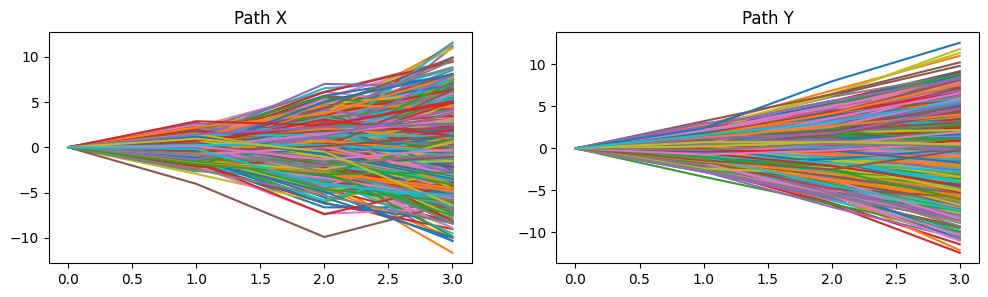

In [16]:
noise1 = np.random.normal(size=[dim, n_sample])
noise2 = np.random.normal(size=[dim, n_sample])
# Create paths (each column is a path, with dim entries)
X = L @ noise1
Y = M @ noise2
# Prepend a trivial first step (e.g. zero)
X = np.concatenate([np.zeros_like(X[:1]), X], axis=0)  # now shape becomes (dim+1, n_sample)
Y = np.concatenate([np.zeros_like(Y[:1]), Y], axis=0)

# Plot the raw paths
fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(X)
ax[0].set_title("Path X")
ax[1].plot(Y)
ax[1].set_title("Path Y")
plt.show()

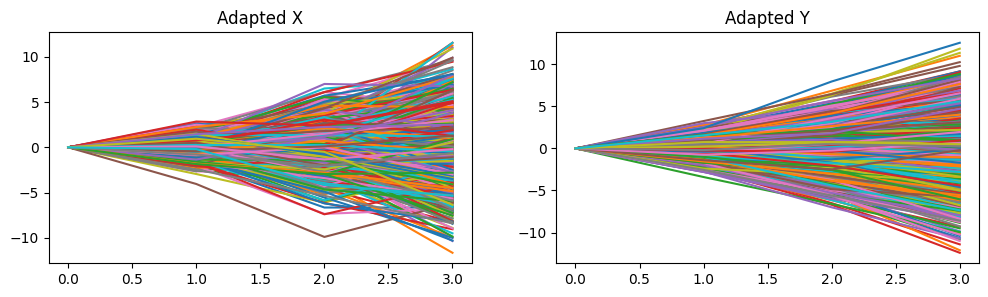

In [17]:
def adapted_empirical_measure(samples, delta_n):
    # Apply a grid quantization to each sample value
    grid_func = lambda x: np.floor(x / delta_n + 0.5) * delta_n
    adapted_samples = grid_func(samples)
    return adapted_samples

adaptedX = adapted_empirical_measure(X, delta_n=0.05)
adaptedY = adapted_empirical_measure(Y, delta_n=0.05)

# Plot the quantized paths
fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(adaptedX)
ax[0].set_title("Adapted X")
ax[1].plot(adaptedY)
ax[1].set_title("Adapted Y")
plt.show()

In [18]:
# Build the common grid: note that we take unique grid values over all time steps and samples
q2v_list = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
v2q_dict = {k: v for v, k in enumerate(q2v_list)}
print("Number of unique grid values:", len(q2v_list))

Number of unique grid values: 383


In [19]:
T = X.shape[0]

def path2cm(adaptedpath):
    """
    Convert each path (a sequence of quantized grid values) into a list of conditional measures.
    Each element mu_x[t] is a dictionary mapping the quantized path up to time t to a histogram
    of the next grid value.
    """
    mu_x = [defaultdict(dict) for t in range(T - 1)]
    for path in adaptedpath.T:
        for t in range(T - 1):
            pre_path = tuple(v2q_dict[v] for v in path[: t + 1])
            next_val = v2q_dict[path[t + 1]]
            if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
                mu_x[t][pre_path][next_val] = 1
            else:
                mu_x[t][pre_path][next_val] += 1
    return mu_x

mu_x = path2cm(adaptedX)
nu_y = path2cm(adaptedY)

In [20]:
def adapted_wasserstein_squared(a, A, b, B):
    # Cholesky decompositions: A = L L^T, B = M M^T
    L = np.linalg.cholesky(A)
    M = np.linalg.cholesky(B)
    # Mean squared difference
    mean_diff = np.sum((a - b) ** 2)
    # Trace terms
    trace_sum = np.trace(A) + np.trace(B)
    # L1 norm of diagonal elements of L^T M
    l1_diag = np.sum(np.abs(np.diag(L.T @ M)))
    # Final adapted Wasserstein squared distance
    return mean_diff + trace_sum - 2 * l1_diag


a, b = np.zeros([4]), np.zeros([4])
dist_bench = adapted_wasserstein_squared(a, A, b, B)
print("Theoretical AW_2^2: ", dist_bench)

Theoretical AW_2^2:  10.0


In [21]:
square_cost_matrix = (q2v_list[None, :] - q2v_list[None, :].T) ** 2

# We store the recursive values in a dictionary for each time t.
# For the last step (t = T-2), compute the Wasserstein distances directly.
V_list = {}  # keys: time index t, values: dict with keys (pre_path_x, pre_path_y)
t = T - 2
V_list[t] = {}
for k1, v1 in mu_x[t].items():
    for k2, v2 in nu_y[t].items():
        w1 = np.array(list(v1.values()), dtype=float)
        w1 = w1 / np.sum(w1)
        w2 = np.array(list(v2.values()), dtype=float)
        w2 = w2 / np.sum(w2)
        square_cost = square_cost_matrix[np.ix_(list(v1.keys()), list(v2.keys()))]
        dist_W2square = ot.emd2(w1, w2, square_cost)
        V_list[t][(k1, k2)] = dist_W2square

# Backward recursion from t = T-3 down to t = 0.
for t in reversed(range(T - 2)):
    V_list[t] = {}
    for k1, v1 in mu_x[t].items():
        for k2, v2 in nu_y[t].items():
            w1 = np.array(list(v1.values()), dtype=float)
            w1 = w1 / np.sum(w1)
            w2 = np.array(list(v2.values()), dtype=float)
            w2 = w2 / np.sum(w2)
            q1s = list(v1.keys())
            q2s = list(v2.keys())
            # Base cost between the current grid values
            square_cost = square_cost_matrix[np.ix_(q1s, q2s)]
            # Add the recursive cost from the next step
            for i, q1 in enumerate(q1s):
                for j, q2 in enumerate(q2s):
                    q_pair = (k1 + (q1,), k2 + (q2,))
                    square_cost[i, j] += V_list[t+1].get(q_pair, 0)
            dist_W2square = ot.emd2(w1, w2, square_cost)
            V_list[t][(k1, k2)] = dist_W2square

# Since the first time step is trivial (all zeros), there is only one key.
AW_squared = list(V_list[0].values())[0]
print("\nNumerical adapted Wasserstein squared distance:", AW_squared)


Numerical adapted Wasserstein squared distance: 10.917701215657928


In [23]:


X_new = np.column_stack((X[0], X[1], X[2], X[3]))
Y_new = np.column_stack((Y[0], Y[1], Y[2], Y[3]))

new_sample_pathsA, new_weightsA = uniform_empirical_grid_measure(X_new, delta_n=0.05, use_weights=True)
new_sample_pathsB, new_weightsB = uniform_empirical_grid_measure(Y_new, delta_n=0.05, use_weights=True)

tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)

max_depth_tree = get_depth(tree2)
start_time_tree = time()
distance_tree = compute_nested_distance(
    tree1,
    tree2,
    max_depth_tree,
    method="solver_lp_pot",
    return_matrix=False,
    lambda_reg=0,
    power=2,
)
elapsed_time_tree = time() - start_time_tree

print(distance_tree)
print(elapsed_time_tree)

10.917701215657926
370.2118167877197
